# Voting (회귀) 하이퍼파라미터 튜닝

## #01. 준비작업

### [1] 패키지 가져오기

In [22]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action='ignore')

from helper.core import *
from helper.util import *
from helper.plot import *
from helper.analysis import *
from helper.classification import *
from helper.regression import *

# 보팅 회귀
from sklearn.ensemble import VotingRegressor

# 회귀모형 클래스
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor

# 하이퍼파라미터 튜닝 객체
from sklearn.model_selection import RandomizedSearchCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### #02. 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/mldata/boston.xlsx")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB
None

데이터프레임 상위 5개 행
+----+---------+------+---------+--------+-------+-------+-------+--------+-------+-------+-----------+--------+---------+--------+
|    |    CRIM |   ZN |   INDUS |   CHAS |   NOX |    RM |   AGE |    DIS |   RAD 

## #02. 데이터 전처리

[1] 훈련/검증 데이터 분할 및 데이터 표준화

In [3]:
x_train, x_test, y_train, y_test = my_train_test_split(origin, 'MEDV', scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((404, 13), (102, 13), (404,), (102,))

## #03. 하이퍼파라미터 튜닝

### [1] Voting에 참여시킬 개별 알고리즘 객체 생성

In [4]:
lrg = get_estimator(classname=LinearRegression)
rgr = get_estimator(classname=Ridge)
lsr = get_estimator(classname=Lasso)
knr = get_estimator(classname=KNeighborsRegressor)
dtr = get_estimator(classname=DecisionTreeRegressor)
svr = get_estimator(classname=SVR)
sgdr = get_estimator(classname=SGDRegressor)

lrg, rgr, lsr, knr, dtr, svr, sgdr

(LinearRegression(n_jobs=-1),
 Ridge(max_iter=1000, random_state=1000),
 Lasso(random_state=1000),
 KNeighborsRegressor(n_jobs=-1),
 DecisionTreeRegressor(random_state=1000),
 SVR(max_iter=1000),
 SGDRegressor(early_stopping=True, random_state=1000))

### [2] 보팅 분류기 생성

In [5]:
vo = VotingRegressor(
    # 결합할 알고리즘의 리스트 (이름, 알고리즘객체) - 이름은 개발자가 마음대로 지정
    #estimators=[('lrg', lrg), ('rgr', rgr), ('lsr', lsr), ('knr', knr), ('dtr', dtr), ('svr', svr), ('sgdr', sgdr)],
    estimators=[('lrg', lrg), ('rgr', rgr), ('lsr', lsr), ('knr', knr), ('dtr', dtr)],
    n_jobs=-1)

### [3] 모듈을 통한 기본 하이퍼파라미터 가져오기

In [6]:
lr_params = get_hyper_params(classname=LinearRegression, key='lrg')
lr_params

{'lrg__fit_intercept': [True, False]}

In [7]:
rgr_params = get_hyper_params(classname=Ridge, key='rgr')
rgr_params

{'rgr__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
 'rgr__solver': ['auto',
  'svd',
  'cholesky',
  'lsqr',
  'sparse_cg',
  'sag',
  'saga']}

In [8]:
lsr_params = get_hyper_params(classname=Lasso, key='lsr')
lsr_params

{'lsr__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
 'lsr__selection': ['cyclic', 'random']}

In [9]:
knr_params = get_hyper_params(classname=KNeighborsRegressor, key='knr')
knr_params

{'knr__n_neighbors': array([2, 3, 4, 5, 6, 7, 8, 9]),
 'knr__weights': ['uniform', 'distance'],
 'knr__metric': ['euclidean', 'manhattan', 'minkowski']}

In [10]:
dtr_params = get_hyper_params(classname=DecisionTreeRegressor, key='dtr')
dtr_params

{'dtr__criterion': ['squared_error',
  'friedman_mse',
  'absolute_error',
  'poisson'],
 'dtr__splitter': ['best', 'random']}

In [11]:
svr_params = get_hyper_params(classname=SVR, key='svr')
svr_params

{'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
 'svr__C': [0.001, 0.01, 0.1, 1, 10],
 'svr__epsilon': [0.1, 0.2, 0.3, 0.4, 0.5],
 'svr__gamma': ['scale', 'auto']}

In [12]:
sgdr_params = get_hyper_params(classname=SGDRegressor, key='sgdr')
sgdr_params

{'sgdr__loss': ['squared_loss',
  'huber',
  'epsilon_insensitive',
  'squared_epsilon_insensitive'],
 'sgdr__penalty': ['l2', 'l1', 'elasticnet'],
 'sgdr__alpha': [0.001, 0.01, 0.1],
 'sgdr__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']}

### [4] Voting용 하이퍼 파라미터로 생성

회귀를 위한 Voting의 경우 soft, hard를 구분하지 않는다.

In [13]:
params = {}
params.update(lr_params)
params.update(rgr_params)
params.update(lsr_params)
params.update(knr_params)
params.update(dtr_params)
#arams.update(svr_params)
#params.update(sgdr_params)

### [5] 하이퍼파라미터 튜닝

In [14]:
rcv = RandomizedSearchCV(
    estimator=vo, 
    param_distributions=params, 
    n_iter=get_max_iter(), 
    n_jobs=get_n_jobs(),
    random_state=get_random_state(), 
    cv=5)

rcv.fit(x_train, y_train)

result_df = DataFrame(rcv.cv_results_['params'])
result_df['mean_test_score'] = rcv.cv_results_['mean_test_score']
result_df.sort_values(by='mean_test_score', ascending=False)

result_df

,rgr__solver,rgr__alpha,lsr__selection,lsr__alpha,lrg__fit_intercept,knr__weights,knr__n_neighbors,knr__metric,dtr__splitter,dtr__criterion,mean_test_score
0,svd,0.100,cyclic,0.010,True,distance,7,euclidean,best,friedman_mse,0.781608
1,svd,10.000,random,0.100,False,distance,6,minkowski,best,poisson,0.488888
2,svd,0.100,cyclic,0.100,True,distance,5,manhattan,random,squared_error,0.796525
3,auto,10.000,cyclic,1.000,False,distance,4,minkowski,best,friedman_mse,0.481318
4,sag,10.000,random,0.001,True,distance,4,minkowski,random,poisson,0.778808
...,...,...,...,...,...,...,...,...,...,...,...
995,svd,0.001,cyclic,0.100,False,distance,9,euclidean,random,squared_error,0.492244
996,cholesky,0.010,cyclic,10.000,True,uniform,8,manhattan,random,friedman_mse,0.749021
997,cholesky,0.001,random,10.000,False,distance,7,euclidean,best,absolute_error,0.461280
998,lsqr,0.010,random,100.000,True,uniform,3,euclidean,best,poisson,0.753810


In [18]:
result_df.sort_values('mean_test_score', ascending=False)

,rgr__solver,rgr__alpha,lsr__selection,lsr__alpha,lrg__fit_intercept,knr__weights,knr__n_neighbors,knr__metric,dtr__splitter,dtr__criterion,mean_test_score
402,sparse_cg,10.000,cyclic,0.001,True,distance,2,manhattan,best,absolute_error,0.800688
273,sparse_cg,1.000,random,0.010,True,distance,2,manhattan,random,squared_error,0.800206
328,auto,0.001,random,0.100,True,distance,2,manhattan,random,squared_error,0.799721
190,svd,0.100,random,0.001,True,uniform,2,manhattan,best,absolute_error,0.799540
245,sparse_cg,0.001,random,0.010,True,uniform,2,manhattan,best,absolute_error,0.799489
...,...,...,...,...,...,...,...,...,...,...,...
387,lsqr,10.000,cyclic,100.000,False,uniform,9,minkowski,random,poisson,0.434387
475,lsqr,100.000,random,100.000,False,uniform,7,euclidean,best,squared_error,0.433276
503,sag,100.000,random,100.000,False,uniform,8,euclidean,best,squared_error,0.429091
863,lsqr,100.000,cyclic,100.000,False,uniform,6,minkowski,random,poisson,0.426932


### [6] 성능평가

[회귀분석 성능평가]
+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.909378 |     0.794916 |
| 평균절대오차(MAE)             |      1.95548 |        2.829 |
| 평균제곱오차(MSE)             |       7.6266 |      17.4968 |
| 평균오차(RMSE)                |      2.76163 |      4.18292 |
| 평균 절대 백분오차 비율(MAPE) |      9.56876 |      15.4387 |
| 평균 비율 오차(MPE)           |     -1.79903 |     -5.18324 |
+-------------------------------+--------------+--------------+

[학습곡선]


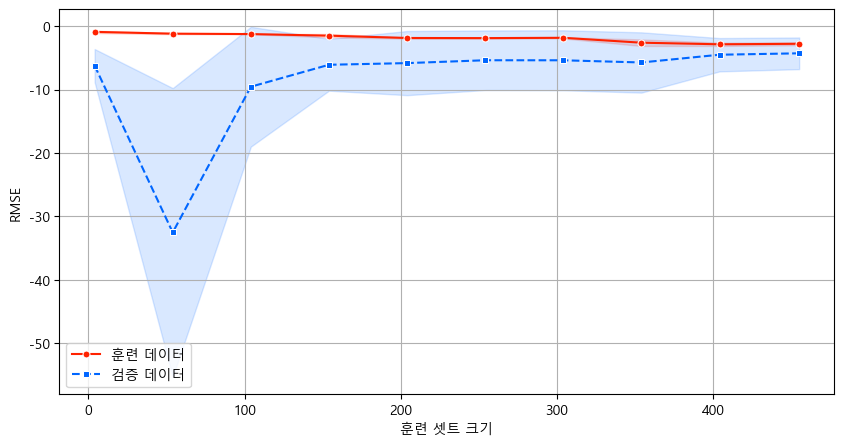

VotingRegressor(estimators=[('lrg', LinearRegression(n_jobs=-1)),
                            ('rgr',
                             Ridge(alpha=10, max_iter=1000, random_state=1000,
                                   solver='sparse_cg')),
                            ('lsr', Lasso(alpha=0.001, random_state=1000)),
                            ('knr',
                             KNeighborsRegressor(metric='manhattan', n_jobs=-1,
                                                 n_neighbors=2,
                                                 weights='distance')),
                            ('dtr',
                             DecisionTreeRegressor(criterion='absolute_error',
                                                   random_state=1000))],
                n_jobs=-1)

In [23]:
my_regression_result(rcv.best_estimator_, x_train, y_train, x_test, y_test)
rcv.best_estimator_

## #04. 모듈화 기능 확인

In [ ]:
my_voting_classification(x_train, y_train, x_test, y_test)